In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import shutil
import gc
from cnn import ConvNet
from model_class import ResNet18
import torchvision.models as models
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

In [6]:
labelMappingDict = {'amur_leopard': 0, 'amur_tiger': 1, 'birds': 2, 'black_bear': 3, 'brown_bear':4, 'dog': 5, 'roe_deer': 6, 'sika_deer': 7, 'wild_boar': 8, 'people': 9}

In [7]:
folderPath = 'C:/Users/ASUS/Desktop/New folder/A1/Q2/russian-wildlife-dataset-20250217T081203Z-001/russian-wildlife-dataset/Cropped_final/'
destinationPath = 'C:/Users/ASUS/Desktop/New folder/A1/Q2/russian-wildlife-dataset-20250217T081203Z-001/russian-wildlife-dataset/private-test/'

In [8]:
ManualSeed = 2022018
torch.manual_seed(ManualSeed)
random.seed(ManualSeed)
np.random.seed(ManualSeed)

In [6]:
# def RandomStratified(fileDictionary):
#     for classKey,classN in fileDictionary.items():
#         classificationPath = folderPath+classKey
#         allImagesOfClass = os.listdir(classificationPath)
#         n = len(allImagesOfClass)
#         test_n = int(0.2 * n)
#         random_indexes = random.sample(range(0, n), test_n)
#         testImages = []
#         for i in random_indexes:
#             testImages.append(allImagesOfClass[i])
#         #print(classKey,':',testImages[0],':',len(testImages))
        
#         os.makedirs(destinationPath+classKey+'/', exist_ok=True)
        
#         for image in testImages:
#             src_path = os.path.join(folderPath+classKey+'/', image)
#             dest_path = os.path.join(destinationPath+classKey+'/', image)

#             if os.path.exists(src_path):  # Check if file exists before moving
#                 shutil.move(src_path, dest_path)
            

In [7]:
#RandomStratified(labelMappingDict)

In [9]:
class dataset(Dataset):
    #defining class transform. Resizes in 256x256 and PIL image type to tensor; dtype becomes float32
    transform = transforms.Compose([transforms.Resize((256, 256)),
    transforms.ToTensor()])
    
    def __init__(self,pathOfFolder,dictionaryLabel):
        #intended to store directories of all animals
        self.animal_directories = []
        #stores the path of the folder which we want to access
        self.pathOfFolder = pathOfFolder
        #Stores tuples of image and the label assigned to it
        self.Timage_directories = []
        
        for animal_name, label in dictionaryLabel.items():
            animal_path = os.path.join(pathOfFolder, animal_name)         
            # List all files in the animal folder
            animal_files = os.listdir(animal_path)
                # Store the directory of this animal
            self.animal_directories.append(animal_path)

            # Filter only .jpg images and store them with their label
            for file in animal_files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_path = os.path.join(animal_path, file)
                    self.Timage_directories.append((image_path, label))
        
    def __len__(self):
        return(len(self.Timage_directories))
            
    def __getitem__(self,index):
        #Getting the image and the label assigned to the image
        image_path,label = self.Timage_directories[index][0],self.Timage_directories[index][1]
        #We open the image using the Image Library
        image = Image.open(image_path)
        #We convert the image to tensor and resize it as well
        tensorImage = dataset.transform(image)
        #returning the image
        return (tensorImage , label)
        
    # def callClassTensors(self,wantedClass):
    #     return self.classTensors[wantedClass]
    def callImNameLabel(self,imageName):
        return self.imNameLabel[imageName]
    def getAllImagesNames(self):
        return self.allImagesNames
    

In [10]:
trainingAnimalSet = dataset(folderPath,labelMappingDict)
trainDataLoader = DataLoader(trainingAnimalSet, batch_size=16, shuffle=True)

In [67]:
# np_img = trainingAnimalSet.callclassTensors('amur_tiger')[100,:,:,:].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
# # Plot using matplotlib
# plt.imshow(np_img)
# plt.show()
# k = trainingAnimalSet.getAllImagesNames()
# k[9000]

In [11]:
testAnimalSet = dataset(destinationPath,labelMappingDict)
testDataLoader = DataLoader(testAnimalSet, batch_size=16, shuffle=True)

In [8]:
print(trainingAnimalSet[1][0].shape)

torch.Size([3, 256, 256])


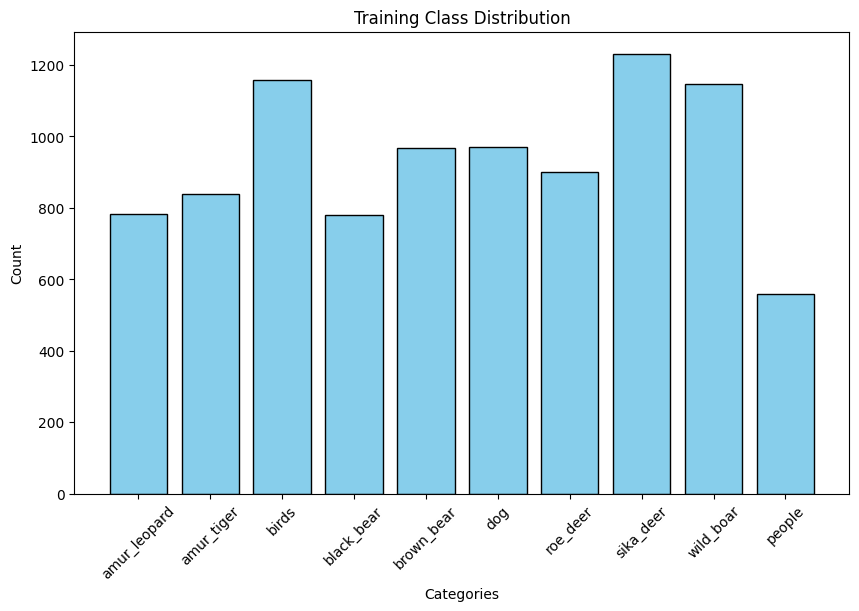

In [69]:
totalImagesinTrain = len(trainingAnimalSet)
totalImagesinTest = len(testAnimalSet)

distribution = [['amur_leopard',0],['amur_tiger', 0], 
 ['birds', 0], 
 ['black_bear', 0], 
 ['brown_bear', 0], 
 ['dog', 0], 
 ['roe_deer', 0], 
 ['sika_deer', 0], 
 ['wild_boar', 0], 
 ['people', 0]]
categories = []
for i in distribution:
    categories.append(i[0])
for i in range(totalImagesinTrain):
    distribution[trainingAnimalSet[i][1]][1] +=1
train = []
for i in distribution:
    train.append(i[1])
#print(distribution)
plt.figure(figsize=(10, 6))
plt.bar(categories, train, color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Training Class Distribution")
plt.xticks(rotation=45)  # Rotate category names for better readability
# Show plot
plt.show()
# for i in range(totalImagesTrain):
#     distribution[trainingAnimalSet[i][1]][1] = 0

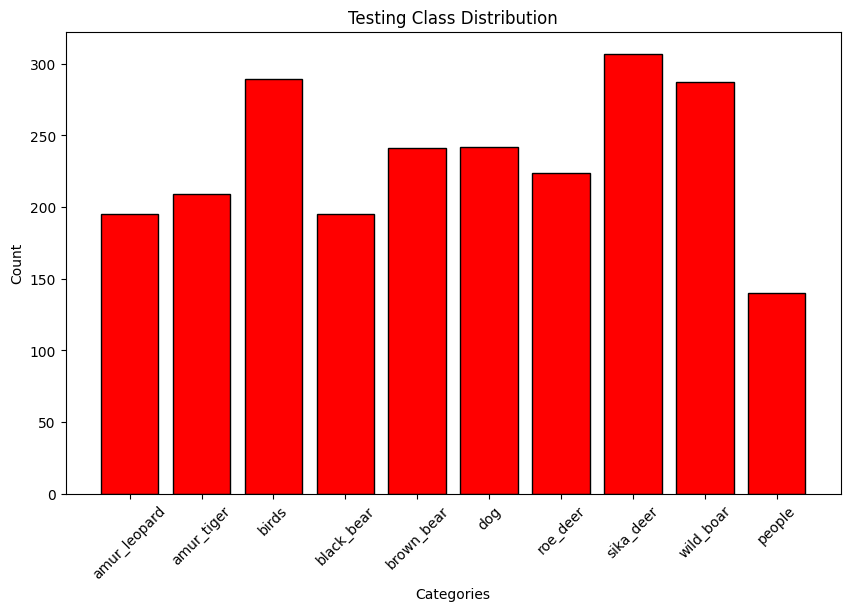

In [71]:
for i in range(totalImagesinTest):
    distribution[testAnimalSet[i][1]][1] =0
for i in range(totalImagesinTest):
    distribution[testAnimalSet[i][1]][1] +=1
test = []
for i in distribution:
    test.append(i[1])
plt.figure(figsize=(10, 6))
plt.bar(categories, test, color='red', edgecolor='black')
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Testing Class Distribution")
plt.xticks(rotation=45)  # Rotate category names for better readability
# Show plot
plt.show()
# print(distribution)

    

In [44]:
print(distribution)

[['amur_leopard', 978], ['amur_tiger', 1049], ['birds', 1446], ['black_bear', 975], ['brown_bear', 1209], ['dog', 1213], ['roe_deer', 1124], ['sika_deer', 1539], ['wild_boar', 1435], ['people', 700]]


In [ ]:
print(torch.cuda.is_available())  # Should print True if GPU is available
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the first GPU

device = "cuda"
gc.collect()  # Forces garbage collection
torch.cuda.empty_cache()  # Clears CUDA memory

# Uses WandB and initialises project as Animal Data Set
wandb.init(project = "Animal Dataset Project")
#Defining model and passing 10 classifications
model = ConvNet(10).to(device)
criterion = nn.CrossEntropyLoss()  # Defining the Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Defining the Adam optimizer
wandb.watch(model)

True
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [48]:
#Defining total num of epochs
nEpochs = 50
for epoch in range(nEpochs):
    model.train()
    total_loss = 0.0
    for batch in trainDataLoader:
        #images= images.to(device)
        #labels = labels.to(device)
        #print(batch[0].shape)
        optimizer.zero_grad()  # Reset gradients
        # outputs = model(images)  # Forward pass
        # loss = criterion(outputs, k)  # Compute loss
        outputs = model(batch[0].float().to(device))  # Forward pass
        loss = criterion(outputs, batch[1].long().to(device))  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()
    num_batches = sum(1 for _ in trainDataLoader)
    avg_loss = total_loss / num_batches
    wandb.log({"epoch": epoch + 1, "loss": avg_loss})
    print(f"Epoch [{epoch}/{nEpochs}], Loss: {avg_loss:.4f}")
    if (epoch + 1) % 5 == 0:  # Save every 5 epochs
        torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
        print(f"Checkpoint saved at epoch {epoch+1}") 
wandb.finish()

Epoch [0/50], Loss: 1.5062
Epoch [1/50], Loss: 1.2295
Epoch [2/50], Loss: 1.0250
Epoch [3/50], Loss: 0.8648
Epoch [4/50], Loss: 0.7002
Checkpoint saved at epoch 5
Epoch [5/50], Loss: 0.5667
Epoch [6/50], Loss: 0.4517
Epoch [7/50], Loss: 0.3570
Epoch [8/50], Loss: 0.2859
Epoch [9/50], Loss: 0.2613
Checkpoint saved at epoch 10
Epoch [10/50], Loss: 0.1895
Epoch [11/50], Loss: 0.1975
Epoch [12/50], Loss: 0.1581
Epoch [13/50], Loss: 0.1562
Epoch [14/50], Loss: 0.1358
Checkpoint saved at epoch 15
Epoch [15/50], Loss: 0.1214
Epoch [16/50], Loss: 0.1143
Epoch [17/50], Loss: 0.0765
Epoch [18/50], Loss: 0.1096
Epoch [19/50], Loss: 0.1128
Checkpoint saved at epoch 20
Epoch [20/50], Loss: 0.0962
Epoch [21/50], Loss: 0.0615
Epoch [22/50], Loss: 0.0830
Epoch [23/50], Loss: 0.0942
Epoch [24/50], Loss: 0.0855
Checkpoint saved at epoch 25
Epoch [25/50], Loss: 0.0721
Epoch [26/50], Loss: 0.0613
Epoch [27/50], Loss: 0.0806
Epoch [28/50], Loss: 0.0702
Epoch [29/50], Loss: 0.0673
Checkpoint saved at epoch 

In [2]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
def evaluate_model(model, dataloader, class_names, device="cuda"):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.float())
            _, preds = torch.max(outputs, 1)  # Get predicted class
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute Accuracy and F1-Score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for class imbalance

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Log metrics to wandB
    wandb.log({"Validation Accuracy": accuracy, "Validation F1-Score": f1})
    wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=all_labels,
        preds=all_preds,
        class_names=class_names
    )})

    model.train()  # Switch back to training mode
    return accuracy, f1

In [13]:
model.load_state_dict(torch.load("convnet.pth"))
wandb.init(project = "Animal Dataset Project")
class_name = [i for i in range(10)]
acc, f1 = evaluate_model(model,testDataLoader,class_name,device)
wandb.finish()

In [12]:
print(acc)

0.6251610133104336


In [13]:
print(f1)

0.6234729530938136


In [12]:
L3ImagesMisclassified = []
for i in range(10):
    L3ImagesMisclassified.append([])

In [13]:
model.eval()

for batch in testDataLoader:
    images = batch[0].float().to(device)
    realClass = batch[1].to(device)
    output = model(images)
    predicted_classes = torch.argmax(output, dim=1)
    NPrealClass = realClass.cpu().numpy()
    NPpredicted_classes = predicted_classes.cpu().numpy()
    
    # print(NPrealClass,NPrealClass.shape)
    # print(NPpredicted_classes,NPrealClass.shape)
    for i in range(NPpredicted_classes.shape[0]):
        # print(NPrealClass[i],NPpredicted_classes[i])
        if (NPrealClass[i] != NPpredicted_classes[i]):
            if len(L3ImagesMisclassified[NPrealClass[i]])<3:
                L3ImagesMisclassified[NPrealClass[i]].append([images[i].cpu(), NPpredicted_classes[i]])


True Class: 0
  Image 1: Misclassified as 2


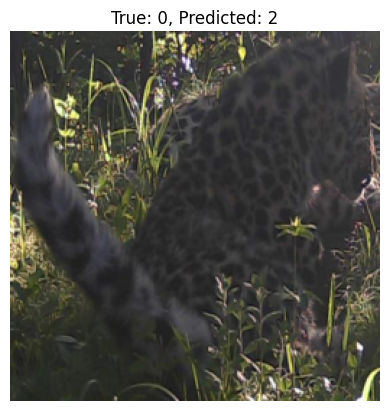

  Image 2: Misclassified as 9


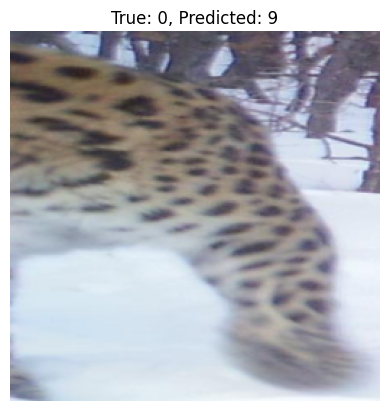

  Image 3: Misclassified as 1


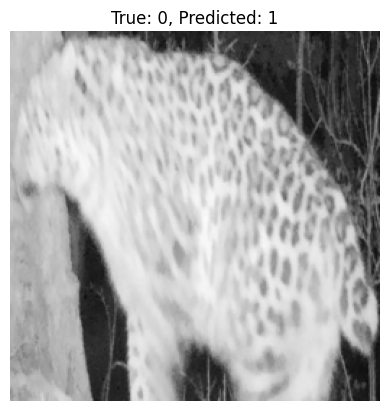

True Class: 1
  Image 1: Misclassified as 7


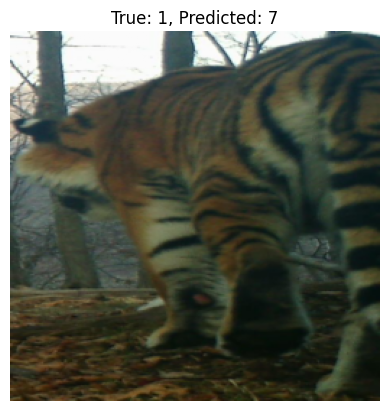

  Image 2: Misclassified as 0


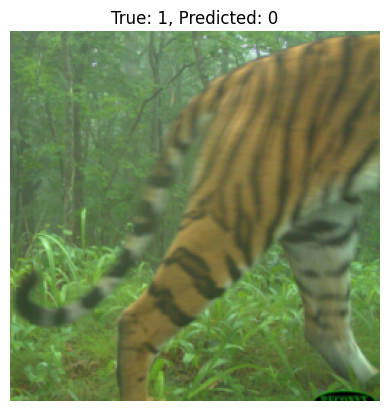

  Image 3: Misclassified as 7


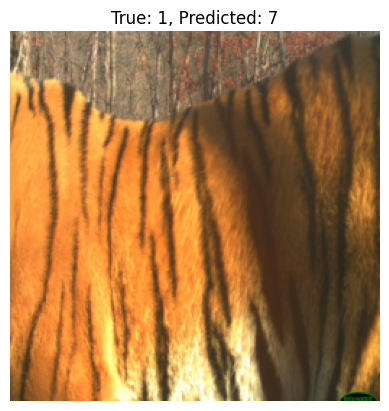

True Class: 2
  Image 1: Misclassified as 5


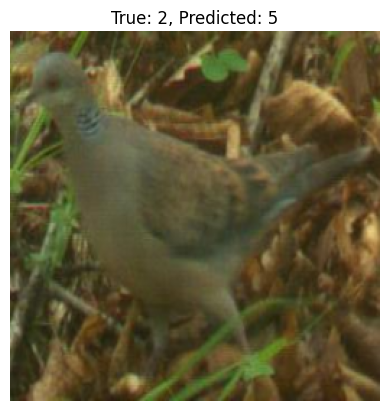

  Image 2: Misclassified as 5


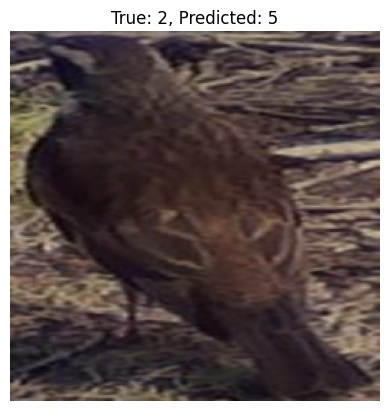

  Image 3: Misclassified as 3


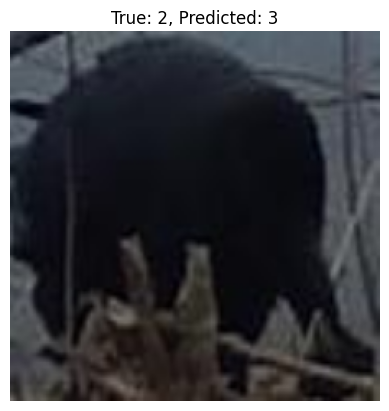

True Class: 3
  Image 1: Misclassified as 5


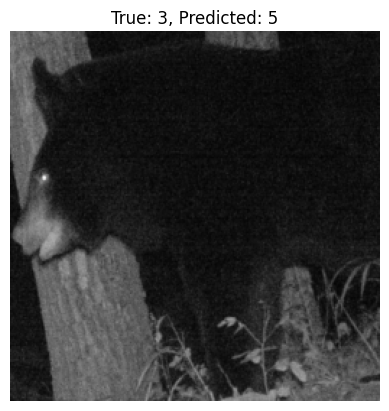

  Image 2: Misclassified as 4


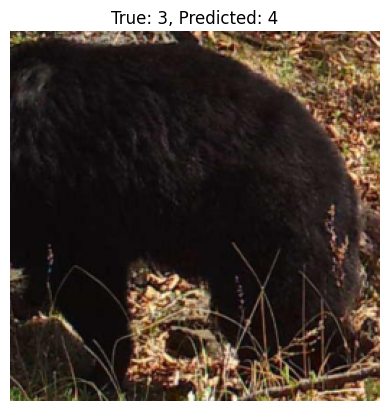

  Image 3: Misclassified as 8


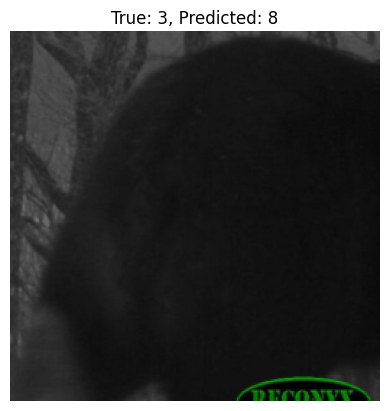

True Class: 4
  Image 1: Misclassified as 3


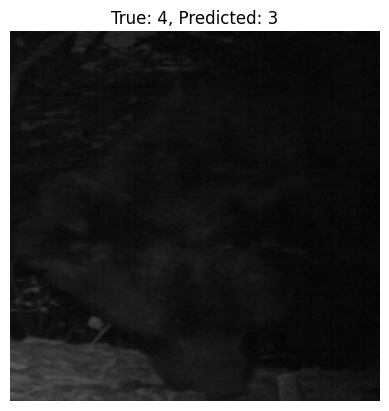

  Image 2: Misclassified as 3


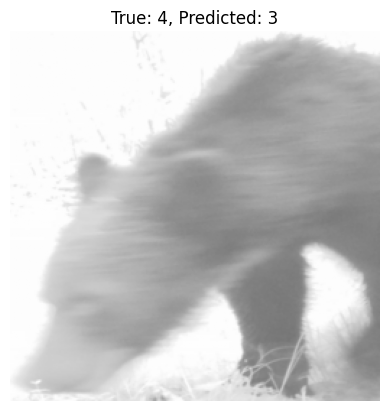

  Image 3: Misclassified as 0


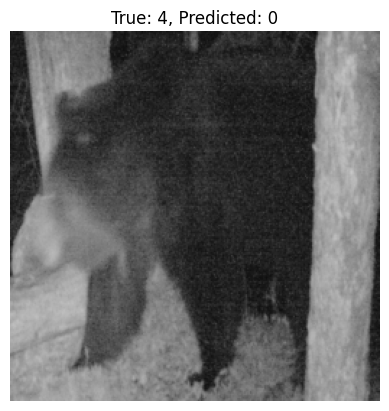

True Class: 5
  Image 1: Misclassified as 6


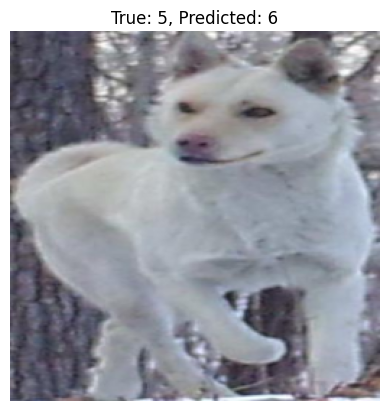

  Image 2: Misclassified as 9


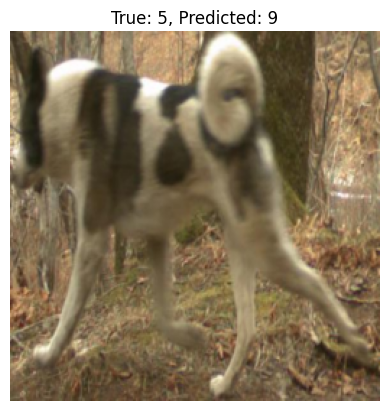

  Image 3: Misclassified as 3


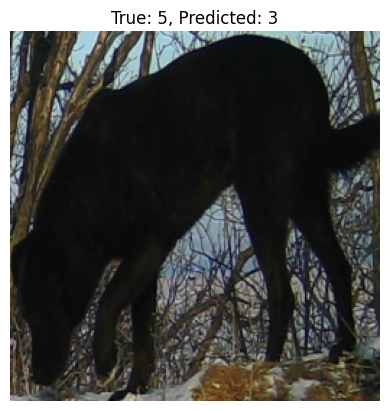

True Class: 6
  Image 1: Misclassified as 3


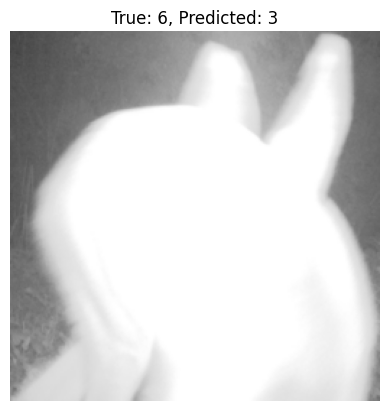

  Image 2: Misclassified as 5


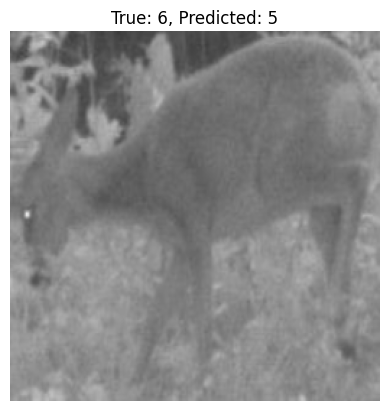

  Image 3: Misclassified as 3


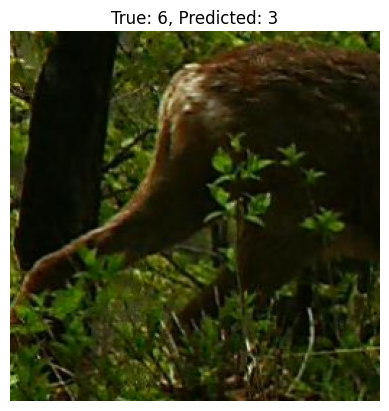

True Class: 7
  Image 1: Misclassified as 6


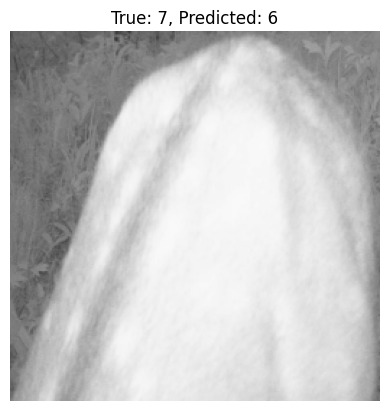

  Image 2: Misclassified as 9


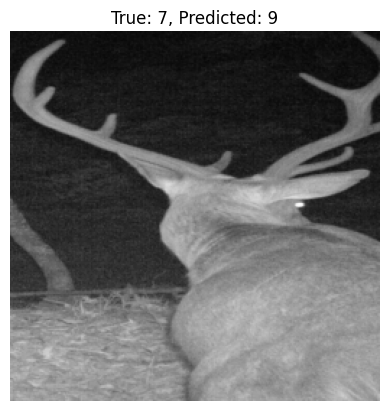

  Image 3: Misclassified as 1


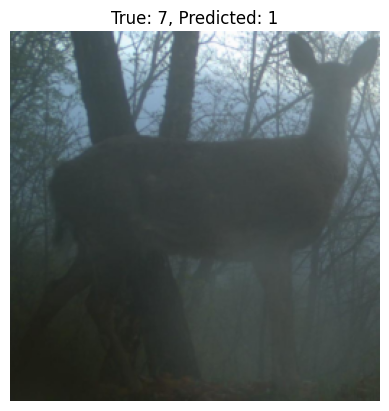

True Class: 8
  Image 1: Misclassified as 4


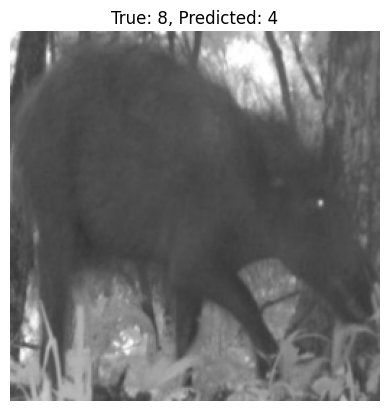

  Image 2: Misclassified as 5


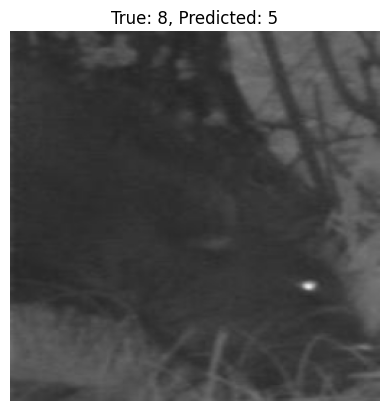

  Image 3: Misclassified as 3


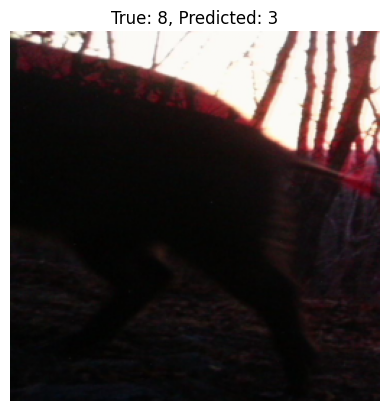

True Class: 9
  Image 1: Misclassified as 5


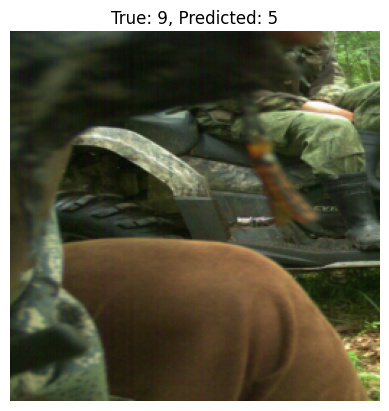

  Image 2: Misclassified as 5


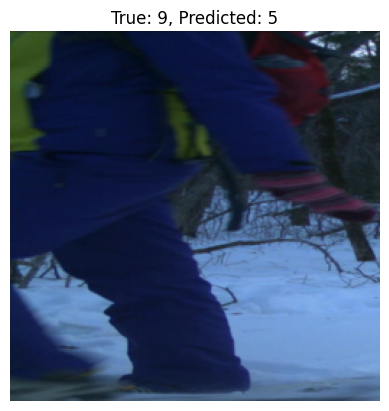

  Image 3: Misclassified as 5


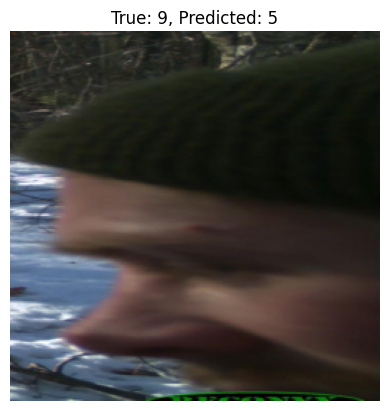

In [47]:
# Iterate over all classes
for true_class in range(10):  # Assuming 10 classes (0-9)
    misclassified_images = L3ImagesMisclassified[true_class]  # List of misclassified images for this class
    
    if len(misclassified_images) == 0:
        continue  # Skip if no misclassified images for this class

    print(f"True Class: {true_class}")  # Print the actual class

    # Iterate over the misclassified samples
    for i, (image_tensor, predicted_class) in enumerate(misclassified_images):
        print(f"  Image {i+1}: Misclassified as {predicted_class}")  # Print misclassification info
        
        # Convert tensor to NumPy and plot
        image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert CHW -> HWC
        plt.imshow(image_np)
        plt.title(f"True: {true_class}, Predicted: {predicted_class}")
        plt.axis("off")
        plt.show()

In [15]:
# Initialize Weights & Biases
wandb.init(project = "Animal Dataset Project", resume="allow")

# Load pretrained ResNet-18
model_resnet = ResNet18()

# Modify the final layer to match the number of classes in your dataset
# num_ftrs = model_resnet.fc.in_features
num_classes = 10  # Update based on your dataset
# model_resnet.fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model.to(device)

resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
num_epochs = 10  # Modify based on your requirement

for epoch in range(num_epochs):
    model_resnet.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainDataLoader:
        images, labels = images.to(device), labels.to(device)

        resnet_optimizer.zero_grad()
        outputs = model_resnet(images.float())
        loss = resnet_criterion(outputs, labels.long())
        loss.backward()
        resnet_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / len(trainDataLoader)
    # Log to wandb
    wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Epoch": epoch+1})

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

print("Training Complete!")


Epoch 1/10 - Loss: 0.0924, Accuracy: 0.9743
Epoch 2/10 - Loss: 0.0831, Accuracy: 0.9769
Epoch 3/10 - Loss: 0.0672, Accuracy: 0.9836
Epoch 4/10 - Loss: 0.0892, Accuracy: 0.9753
Epoch 5/10 - Loss: 0.0817, Accuracy: 0.9769
Epoch 6/10 - Loss: 0.0450, Accuracy: 0.9919
Epoch 7/10 - Loss: 0.0926, Accuracy: 0.9775
Epoch 8/10 - Loss: 0.0885, Accuracy: 0.9787
Epoch 9/10 - Loss: 0.0598, Accuracy: 0.9855
Epoch 10/10 - Loss: 0.0827, Accuracy: 0.9780
Training Complete!


In [39]:
torch.save(model_resnet.state_dict(), "resnet1.pth")
print("Model saved successfully!")

Model saved successfully!


In [16]:
model_resnet.load_state_dict(torch.load("resnet18.pth"))
wandb.init(project = "Animal Dataset Project")

In [18]:
class_name = [i for i in range(10)]
acc, f1 = evaluate_model(model_resnet,testDataLoader,class_name,'cuda')
wandb.finish()

In [41]:
print(acc)

0.6079862601975097


In [42]:
print(f1)

0.6087172360233735


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet.to(device)
model_resnet.eval()

# Remove the last FC layer to use as a feature extractor
backbone = nn.Sequential(*list(model_resnet.children())[:-1])
backbone.to(device)
backbone.eval()


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [21]:
def get_features(model, loader):
    feature_list, label_list = [], []
    
    with torch.no_grad():
        for batch in loader:
            imgs, lbls = batch  # Unpack batch
            imgs = imgs.to(device)
            
            # Extract features and flatten
            vecs = model(imgs).view(imgs.size(0), -1)
            
            feature_list.append(vecs.detach().cpu().numpy())
            label_list.append(lbls.numpy())
    
    return np.vstack(feature_list), np.hstack(label_list)

# Extract features from train and validation data
train_feats, train_lbls = get_features(backbone, trainDataLoader)
val_feats, val_lbls = get_features(backbone, testDataLoader)

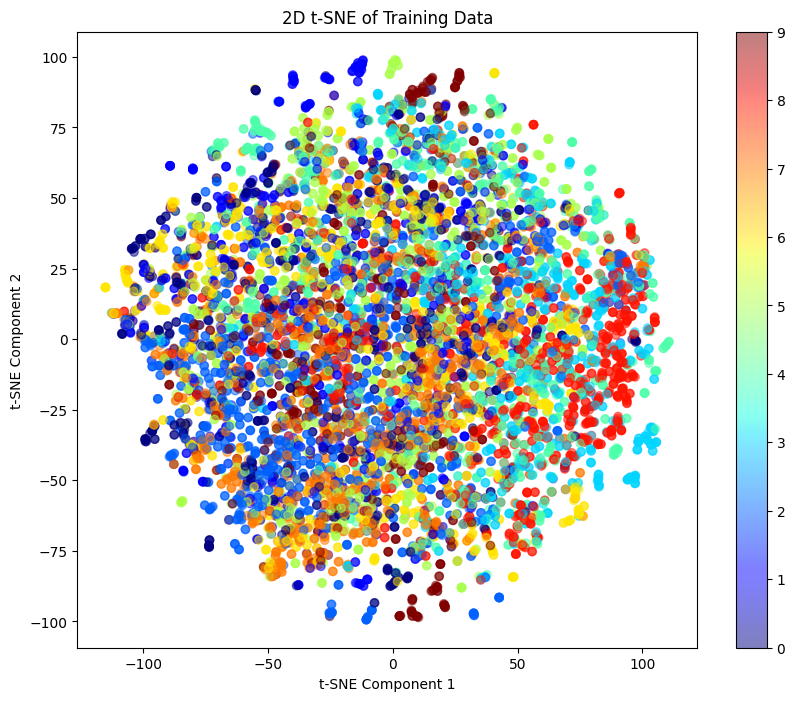

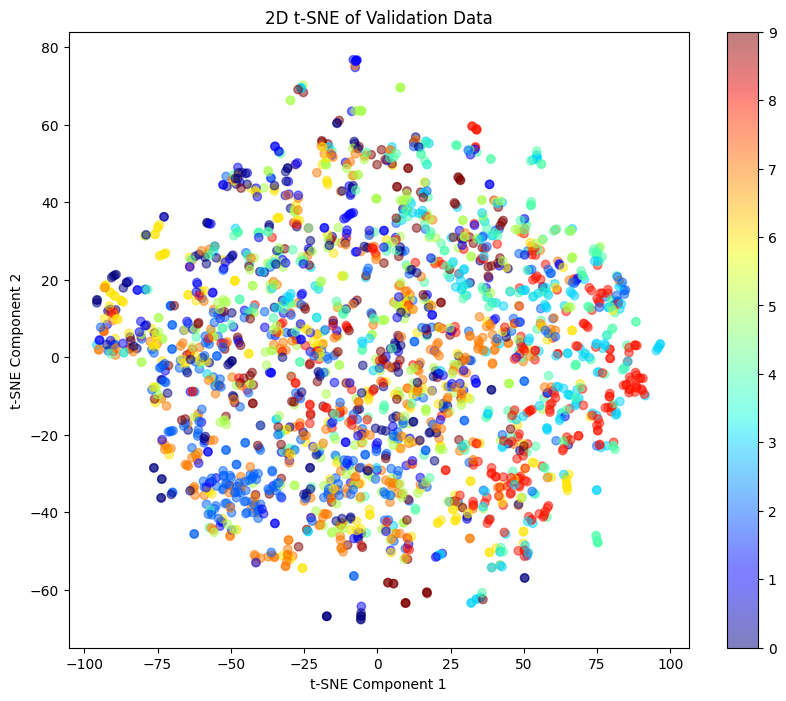

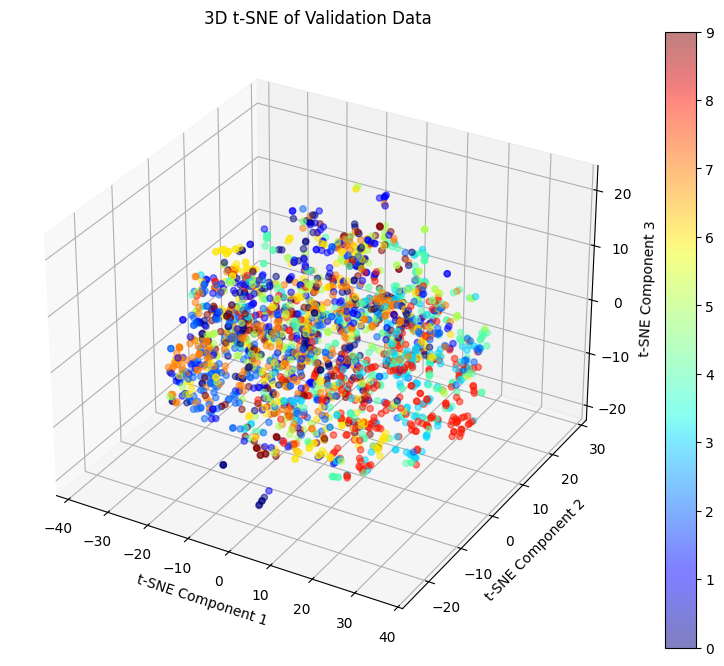

In [24]:
# Apply t-SNE for Dimensionality Reduction
tsne2d = TSNE(n_components=2, perplexity=5, random_state=18)
train_emb_2d = tsne2d.fit_transform(train_feats)
val_emb_2d = tsne2d.fit_transform(val_feats)

tsne3d = TSNE(n_components=3, perplexity=5, random_state=18)
val_emb_3d = tsne3d.fit_transform(val_feats)

# Plot 2D t-SNE for Training Data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_emb_2d[:, 0], train_emb_2d[:, 1], c=train_lbls, cmap="viridis", alpha=0.5)
plt.colorbar(scatter)
plt.title("2D t-SNE of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Plot 2D t-SNE for Validation Data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(val_emb_2d[:, 0], val_emb_2d[:, 1], c=val_lbls, cmap="viridis", alpha=0.5)
plt.colorbar(scatter)
plt.title("2D t-SNE of Validation Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Plot 3D t-SNE for Validation Data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(val_emb_3d[:, 0], val_emb_3d[:, 1], val_emb_3d[:, 2], c=val_lbls, cmap="viridis", alpha=0.5)
plt.colorbar(scatter)
ax.set_title("3D t-SNE of Validation Data")
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.show()
